In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from paths import *
from constants import ALPHAS

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
def get_value_estimates(source: str) -> pd.DataFrame:
    value_estimates = list()
    for alpha in ALPHAS:
        value_estimate = pd.read_csv(
            SEPSIS/f'esprl-results/{source}_value_estimate_{alpha}_tsv'.replace('.', '_'),
            sep='\t')
        value_estimate.rename({f'alpha_{alpha}': 'value_estimate'}, axis=1, inplace=True)
        value_estimate['alpha'] = alpha
        value_estimates.append(value_estimate)
    value_estimates = pd.concat(value_estimates).reset_index(drop=True)
    
    return value_estimates

train_ve = get_value_estimates('train')
test_ve = get_value_estimates('test')

### Marginal distribution of value estimate function

#### Train

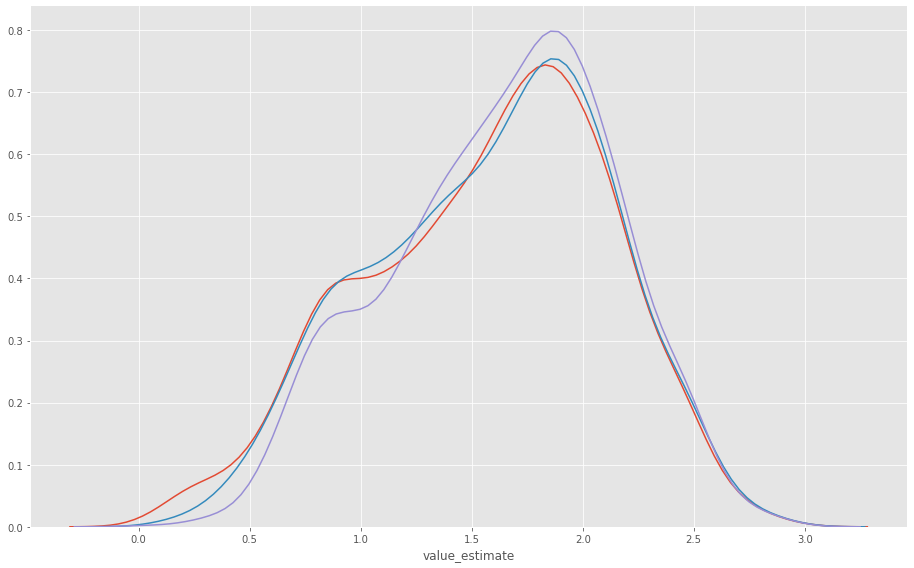

In [3]:
g = sns.FacetGrid(train_ve, hue="alpha", height=8, aspect=1.6)
g.map(sns.distplot, "value_estimate", hist=False);

#### Test

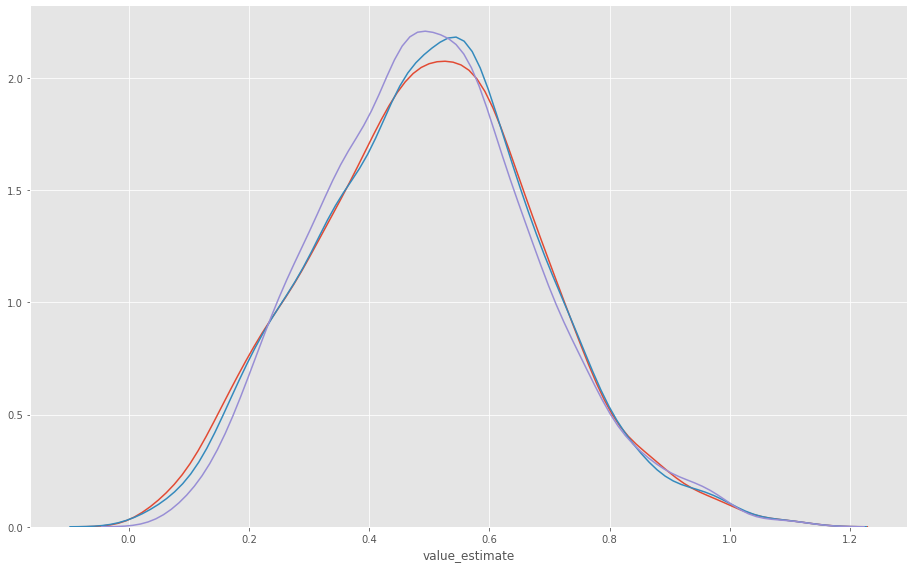

In [4]:
g = sns.FacetGrid(test_ve, hue="alpha", height=8, aspect=1.6)
g.map(sns.distplot, "value_estimate", hist=False);

### Sampling variation of value estimate across states

#### Train

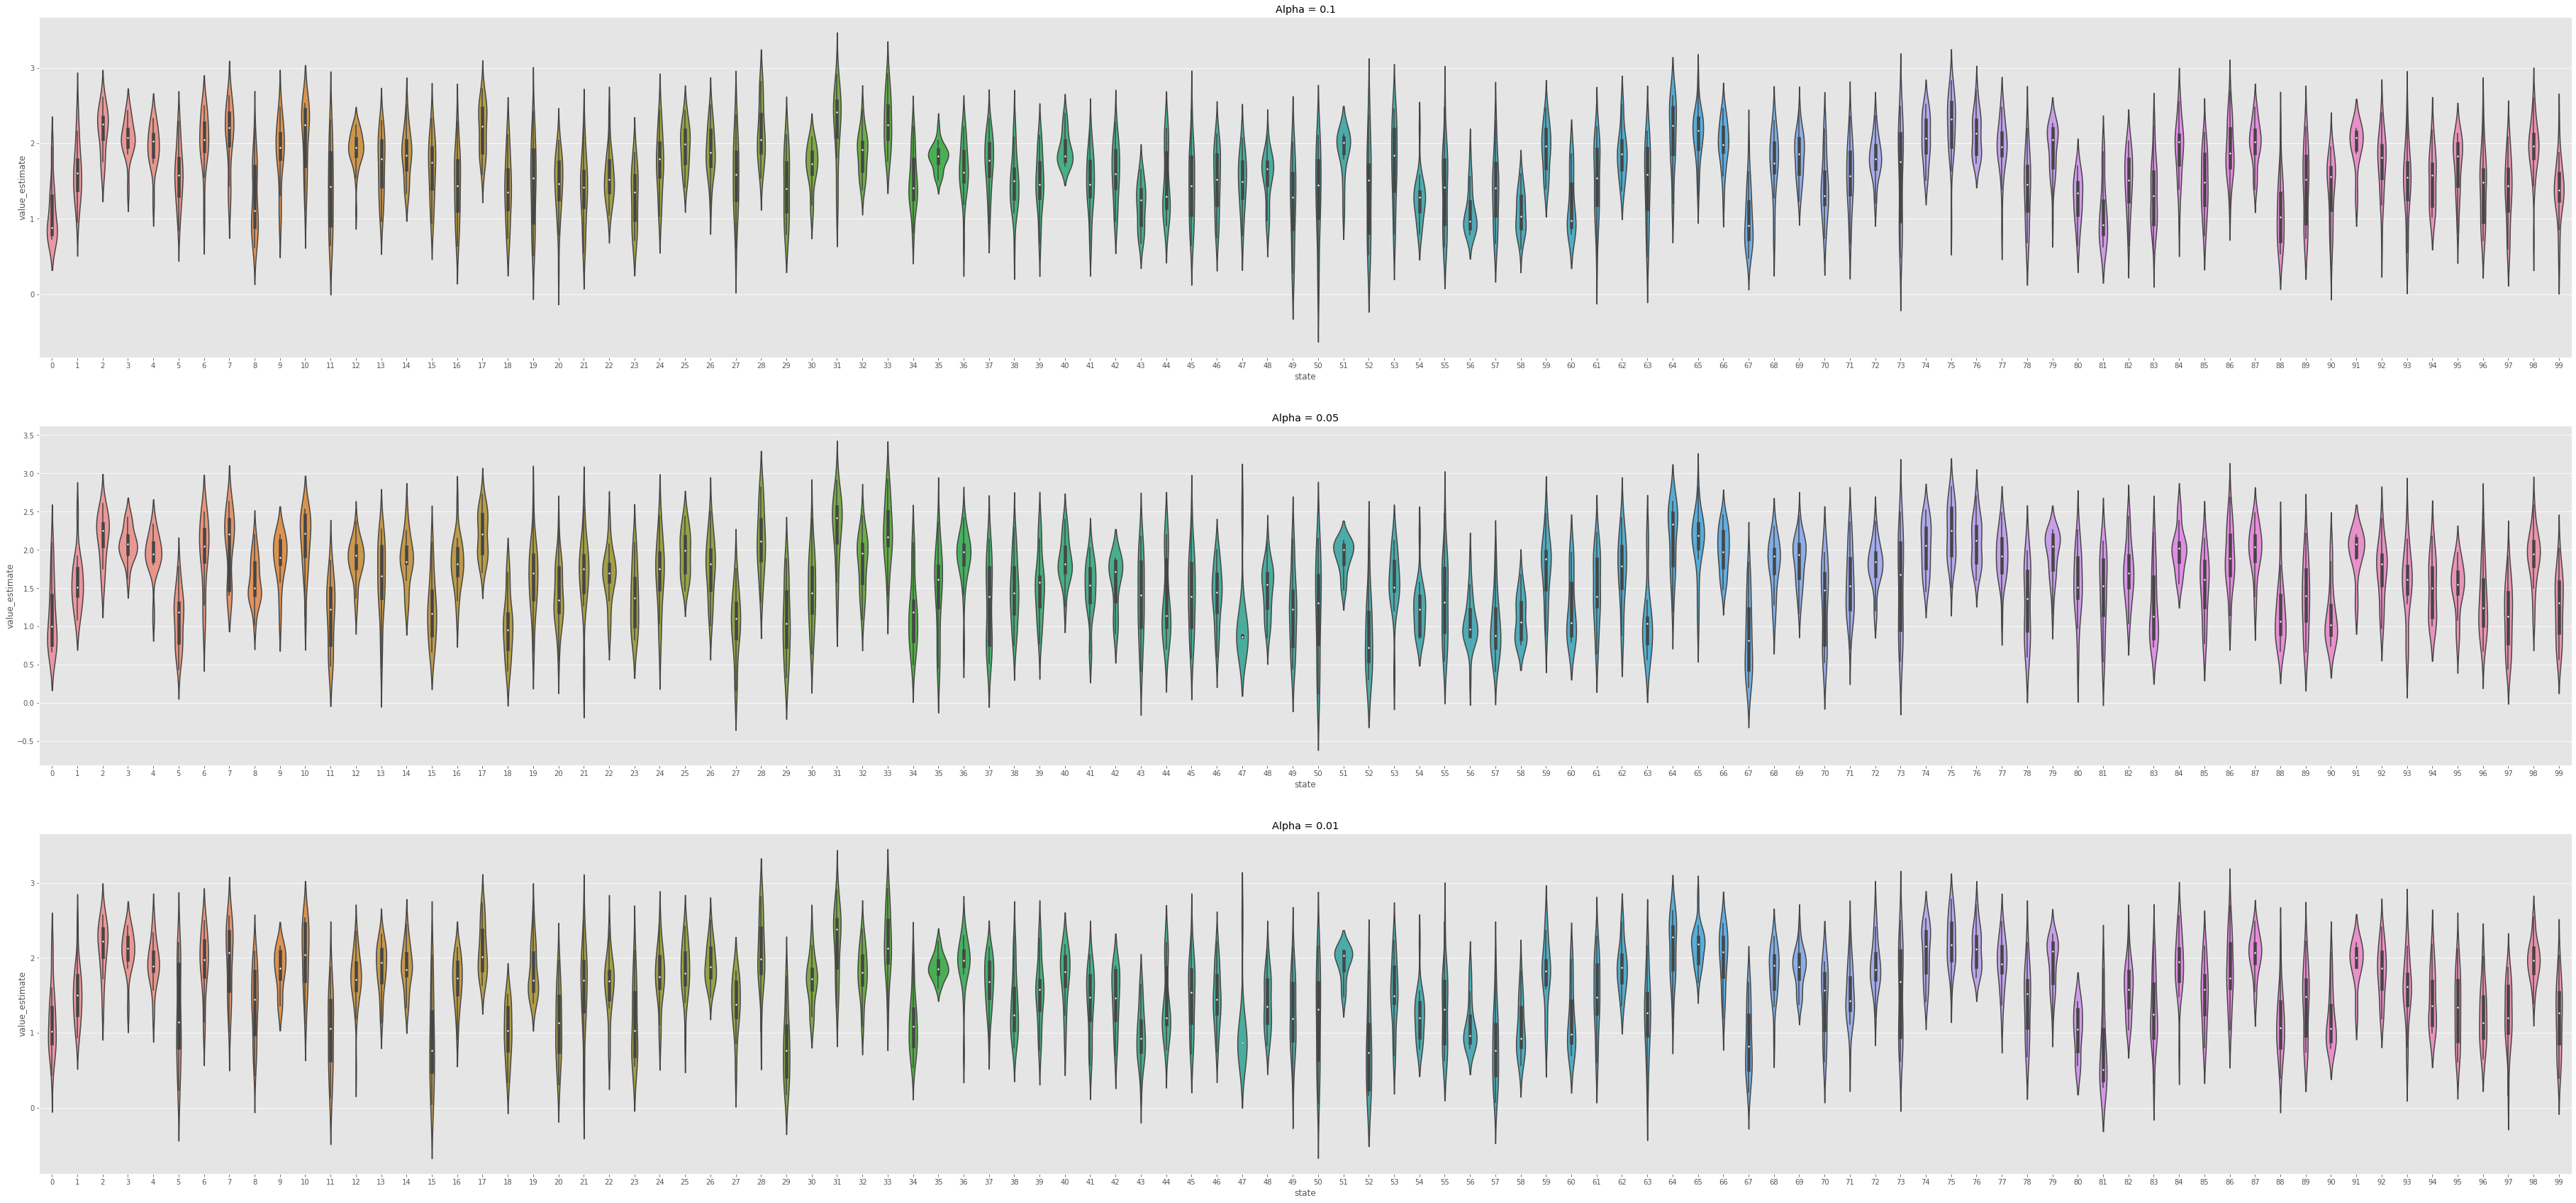

In [5]:
fig, ax = plt.subplots(figsize=(64, 30), nrows=3)
for alpha, axes in zip(ALPHAS, ax):
    sns.violinplot(data=train_ve.loc[train_ve.alpha == alpha],
                   x="state", y="value_estimate", ax=axes)
    axes.set_title(f'Alpha = {alpha}')

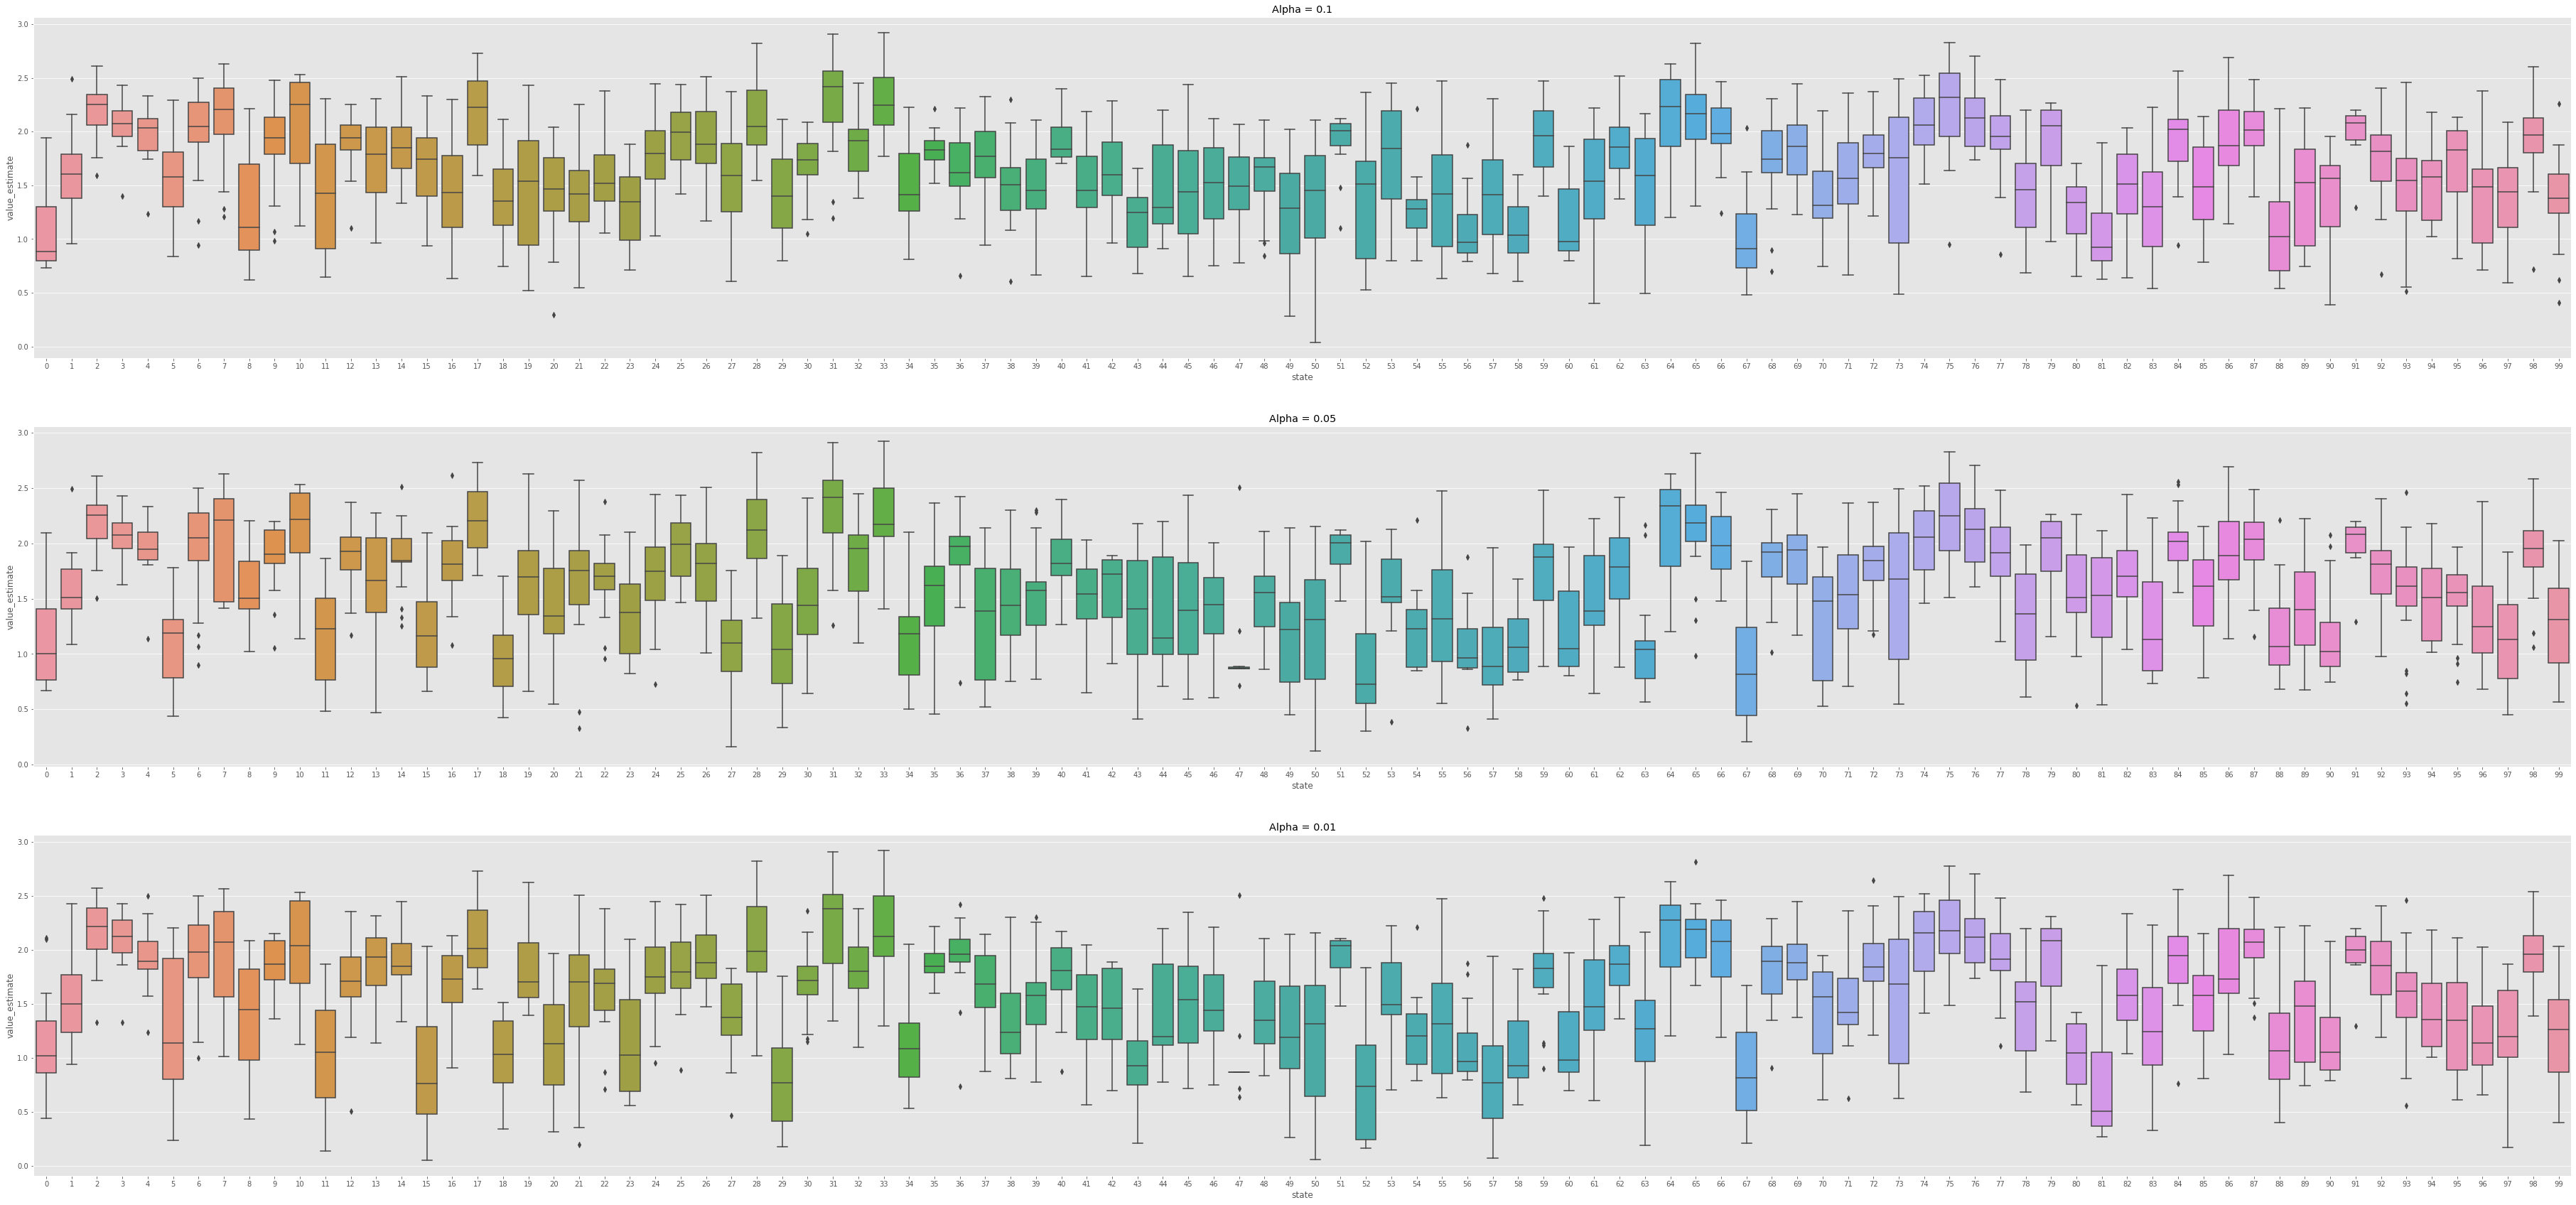

In [6]:
fig, ax = plt.subplots(figsize=(64, 30), nrows=3)
for alpha, axes in zip(ALPHAS, ax):
    sns.boxplot(data=train_ve.loc[train_ve.alpha == alpha],
                x="state", y="value_estimate", ax=axes)
    axes.set_title(f'Alpha = {alpha}')

#### Test

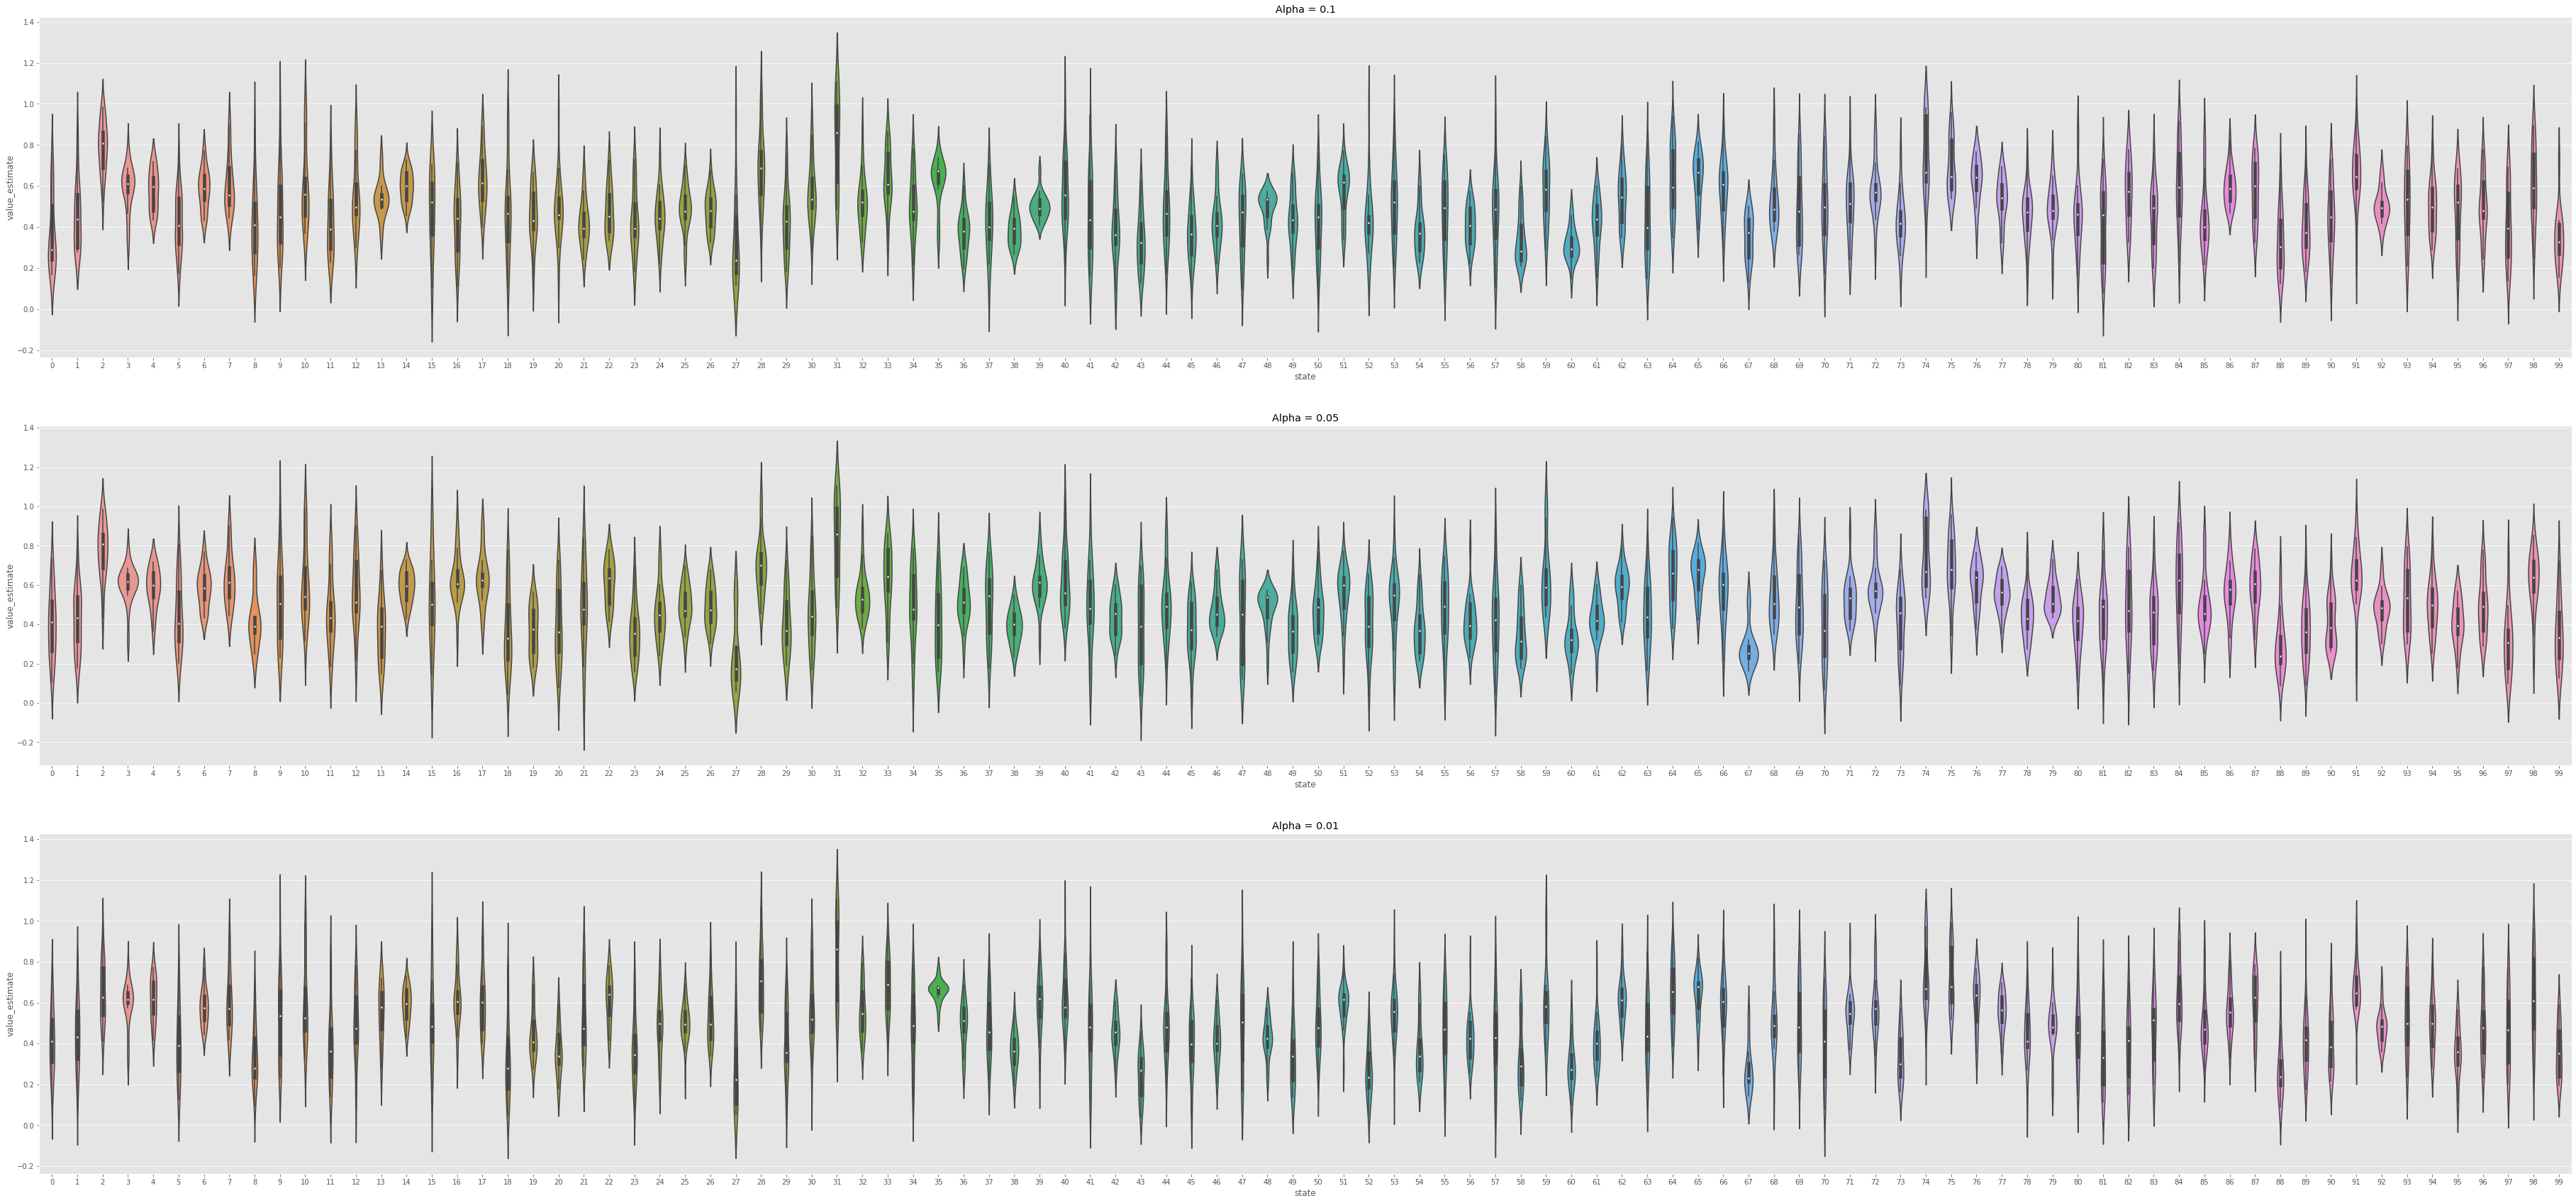

In [7]:
fig, ax = plt.subplots(figsize=(64, 30), nrows=3)
for alpha, axes in zip(ALPHAS, ax):
    sns.violinplot(data=test_ve.loc[test_ve.alpha == alpha],
                   x="state", y="value_estimate", ax=axes)
    axes.set_title(f'Alpha = {alpha}')

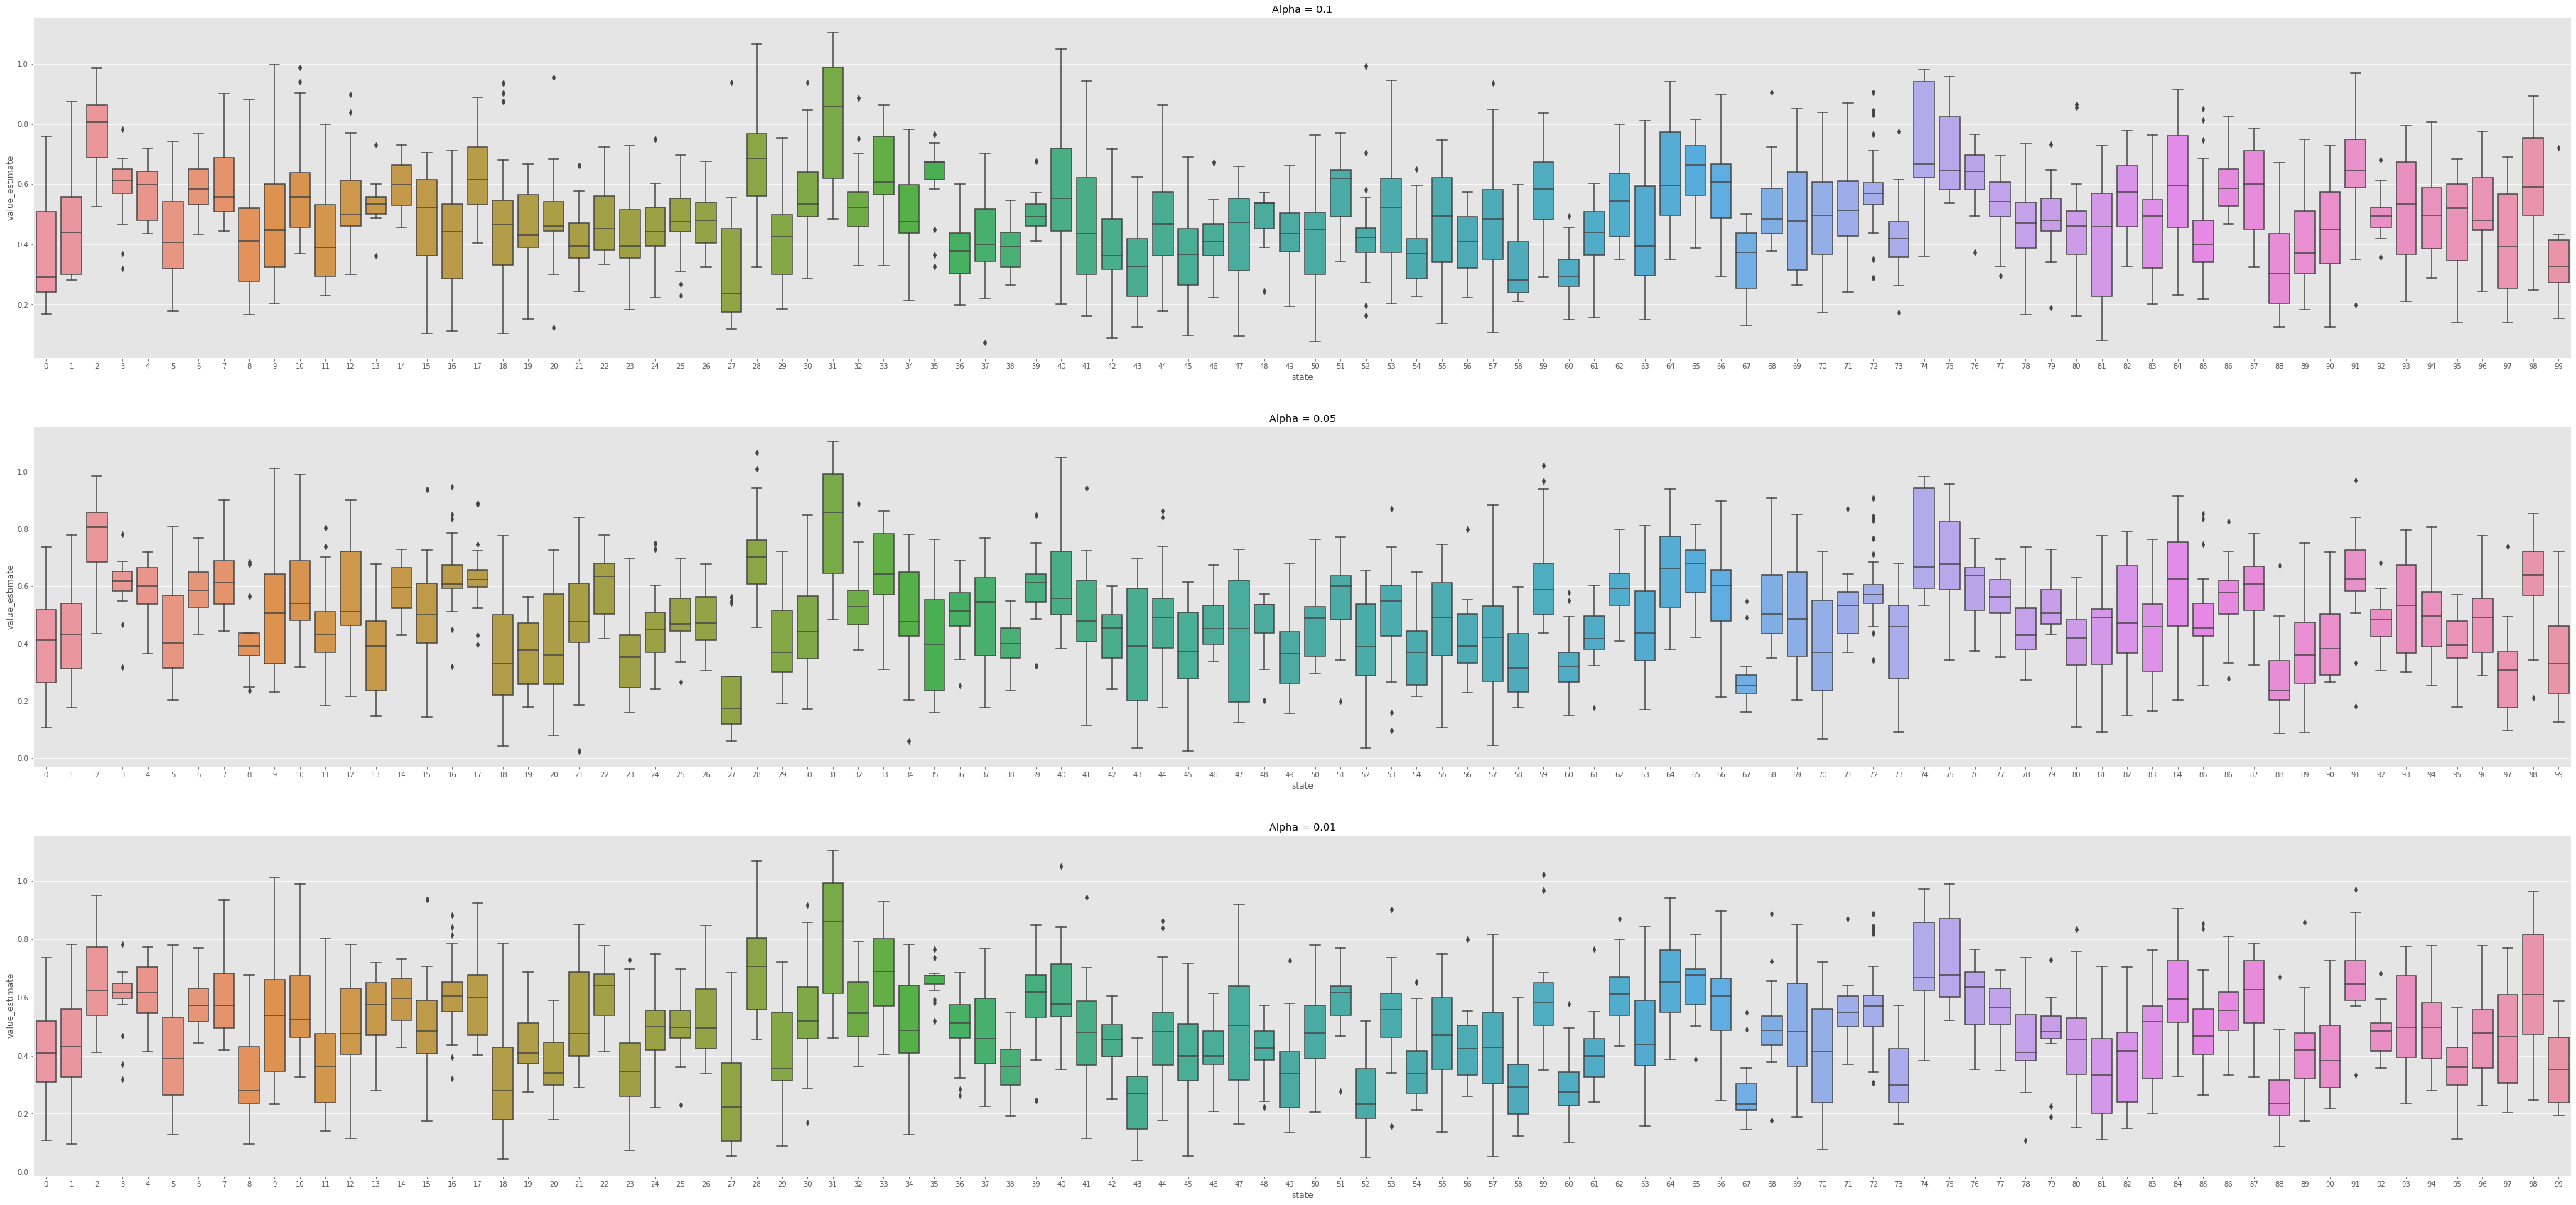

In [8]:
fig, ax = plt.subplots(figsize=(64, 30), nrows=3)
for alpha, axes in zip(ALPHAS, ax):
    sns.boxplot(data=test_ve.loc[test_ve.alpha == alpha],
                x="state", y="value_estimate", ax=axes)
    axes.set_title(f'Alpha = {alpha}')

### Relation between clustering features and value estimate

In [9]:
# Get data relating states to clustering features
clustering_features = pd.read_csv(DATA/'processed/sepsis/clustering_features.tsv', sep='\t')

# Get mean feature value for each cluster
mean_cluster_ftrs = clustering_features.groupby('state').agg(pd.Series.mean).reset_index()

mean_cluster_ftrs.head()

,state,Albumin,Arterial_BE,Arterial_lactate,Arterial_pH,BUN,CO2_mEqL,Calcium,Chloride,Creatinine,...,Weight_kg,age,elixhauser,gender,mechvent,output_4hourly,output_total,paCO2,paO2,re_admission
0,0,3.047806,0.455386,2.462417,7.397338,22.948985,25.842244,8.399647,105.679609,1.315954,...,81.649361,20097.847725,3.607527,0.510753,0.643817,339.705645,3599.918011,40.955959,130.324364,0.169355
1,1,3.022586,-0.148993,1.804401,7.384861,27.651190,24.798631,8.112841,106.642102,1.434158,...,80.126964,26611.756155,5.070845,0.460490,0.356948,275.966394,2165.086285,41.634726,122.171509,0.497729
2,2,3.061137,-0.437069,1.695757,7.378049,24.353883,25.396540,8.261429,105.727741,1.204729,...,81.340026,25052.764561,4.146281,0.405891,0.001997,290.995507,2252.777334,42.068080,108.955012,1.000000
3,3,2.893483,6.439468,1.682740,7.438101,36.157932,32.975071,8.487123,105.163044,1.210645,...,86.405124,26430.951876,5.335911,0.510309,0.831615,368.254296,6426.829897,48.154351,106.674907,0.323024
4,4,2.894403,2.713389,1.610236,7.446092,21.295590,27.590575,8.224230,106.609882,0.877089,...,86.740459,23200.415945,2.905028,0.421089,0.905028,466.325419,9275.356145,39.624346,113.290235,0.070531


In [10]:
def wrangle_ve_ftrs(value_estimate_df):
    if 'alpha' in value_estimate_df.columns:
        mean_ve = value_estimate_df.groupby(['alpha', 'state']).agg(pd.Series.mean).reset_index()
    else:
        mean_ve = value_estimate_df.groupby(['state']).agg(pd.Series.mean).reset_index()
        
    return mean_ve.merge(mean_cluster_ftrs, on='state')
    
    
test_ve_ftrs = wrangle_ve_ftrs(test_ve)

In [41]:
cluster_ftr_names = list(clustering_features.columns[1:])
ridge_ftr_imp = list()

# Params
RIDGE_PENALTY = np.logspace(-3, 3, 100)
CV = 20

for alpha in ALPHAS:
    df = test_ve_ftrs.loc[test_ve_ftrs.alpha == alpha]
    ridge = RidgeCV(alphas=RIDGE_PENALTY, cv=CV, normalize=True, scoring='neg_mean_squared_error')
    ridge = ridge.fit(df[cluster_ftr_names], df['value_estimate'])
    print(f"Ridge CV Negative MSE for alpha {alpha}: {ridge.best_score_}")
    
    order = np.argsort(np.abs(ridge.coef_))[::-1]
    ridge_ftr_imp.append(
        pd.DataFrame({
            'feature': np.array(cluster_ftr_names)[order], 
            'coefficient': ridge.coef_[order],
            'alpha': alpha
        }))

ridge_ftr_imp = pd.concat(ridge_ftr_imp).reset_index(drop=True)

Ridge CV Negative MSE for alpha 0.1: -0.008481045336014617
Ridge CV Negative MSE for alpha 0.05: -0.010246635595031299
Ridge CV Negative MSE for alpha 0.01: -0.010578335653385978


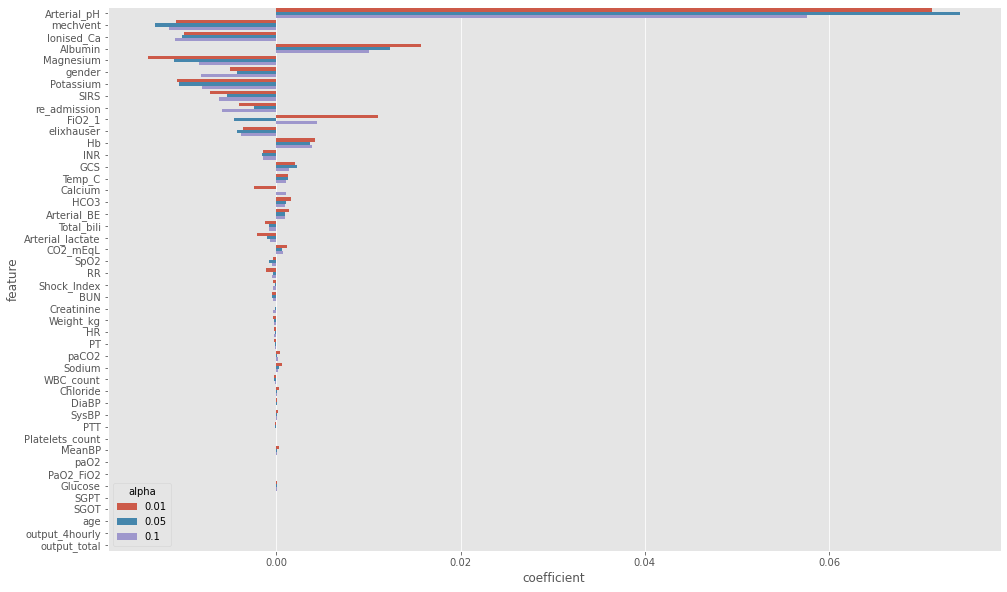

In [45]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(data=ridge_ftr_imp, x='coefficient', y='feature', hue='alpha', ax=ax);